# Nicholas Cruz
# February 26, 2023
# Recognizing Handwritten Digits with k-Nearest-Neighbor Classification Algorithm

## Introduction

In this report, we will utilize the k-nearest neighbor algorithm to classify handwritten digits from the MNIST database. We will build the kNN model from scratch then explore its performance.

## Retrieving MNIST Data

We will pull the MNIST data from the web then convert the images into numpy arrays.

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from pathlib import Path
import requests
import gzip

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# function to pull data from web and store in global vars
def get_MNIST():
    
    # urls for files
    mnist_url = "http://yann.lecun.com/exdb/mnist/"
    img_file = "train-images-idx3-ubyte.gz"
    labels_file = "train-labels-idx1-ubyte.gz"

    # get files from web if not in wd
    for fname in [img_file, labels_file]:
        if Path(fname).is_file() :
            print(f"Found: {fname}")
            continue
        print(f"Downloading: {fname}")
        r = requests.get(mnist_url + fname)
        with open(fname, 'wb') as foo:
            foo.write(r.content)   

    # declare images and labels as global
    global images 
    global labels
    
    # convert files into np arrays
    with gzip.open(img_file, 'rb') as foo:
        f = foo.read()
    images = np.array([b for b in f[16:]]).reshape(-1, 28,28)
    with gzip.open("train-labels-idx1-ubyte.gz", 'rb') as foo:
        f = foo.read()
    labels = np.array([b for b in f[8:]])
    
get_MNIST()

Found: train-images-idx3-ubyte.gz
Found: train-labels-idx1-ubyte.gz


### Train/Test Split

In [231]:
# split data into train and test
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)

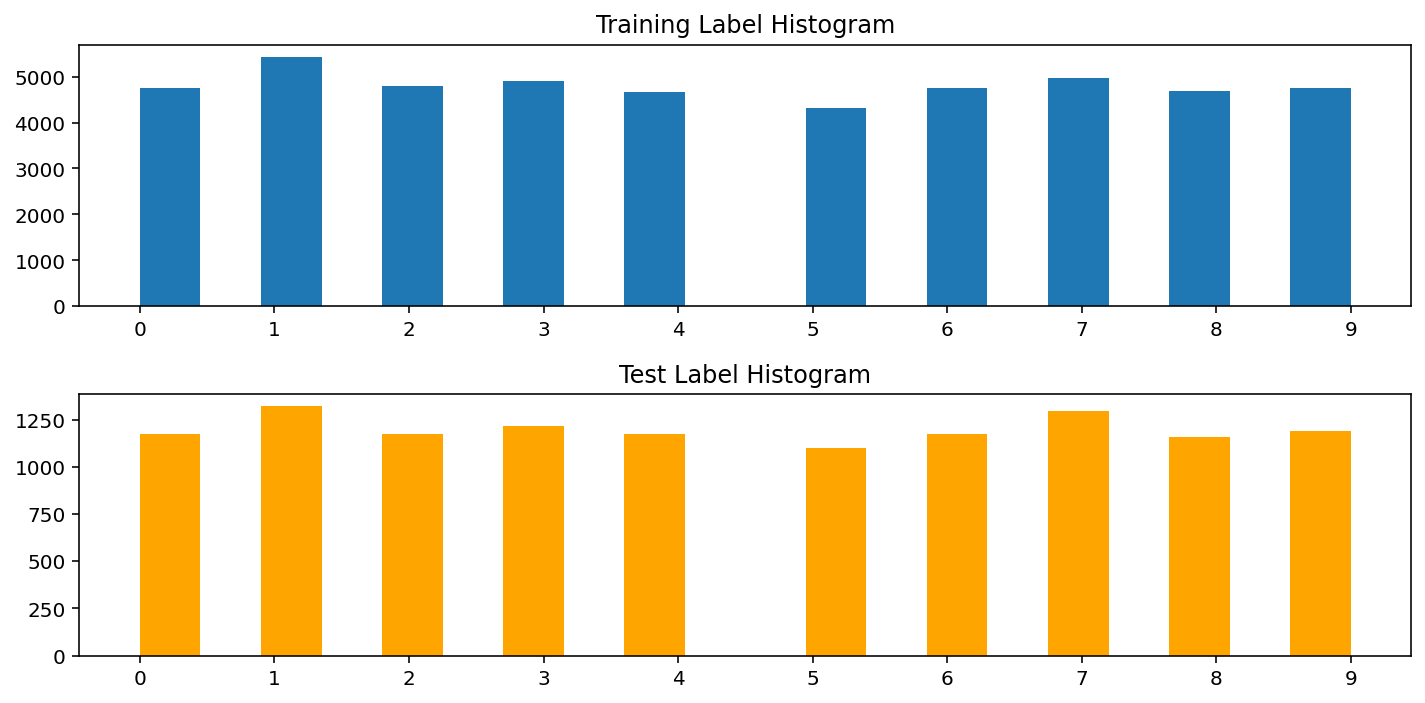

In [329]:
plt.figure(figsize=(10,5))

# distribution of training data
plt.subplot(2,1,1)
plt.hist(label_train,bins=20)
plt.title('Training Label Histogram')
plt.xticks(range(10));

# distribution of test data
plt.subplot(2,1,2)
plt.hist(label_test,bins=20,color='orange')
plt.title('Test Label Histogram')
plt.xticks(range(10));

plt.tight_layout()

## Building the Model

To develop the classifier, we must find the labels of the element closest to the test vector based on Euclidean distance. 

We will use the `find_kNN` function as a helper, which finds `k` amount of nearest neighbors to the test vector based on Euclidean distance.

The function `knn_classifier` will use the helper to obtain the `k` nearest image arrays to the test image `x`. From that array, we will select the furthest neighbor as our final prediction (there are other ways of making this selection).

### Vectorization of kNN Calculation
Because we are dealing with tens of thousands of images, I will choose an approach that avoids for-loops to test new data. Instead of calculating the distance between train and test images one-by-one, we can use linear algebra to perform these calculations simultaneously. Given an array of training images $\vec{X}$ and an array of test images $\vec{p}$, we can rewrite the distance $||X-p||$ as

$$\sqrt{||X||^2+||p||^2-2X\cdot p}.$$

This manipulation allows the distance calculation between training and test data to be performed as a single operation.

In [267]:
def find_kNN(X,p,k):
    dist=np.sqrt((p**2).sum(axis=1)[:, np.newaxis] + (X**2).sum(axis=1) - 2 * p.dot(X.T)) # get all euclidean distances
    return np.argsort(dist)[:,:k] # sort top k neighbor indices

def knn_classifier(training_images, training_labels, x, n):
    
    # reshape appropriately 
    training_images=training_images.reshape((training_images.shape[0], 28*28))
    x=x.reshape((len(x),28*28)) # flatten each image
    
    knn=find_kNN(training_images,x,n) # get locations of knn
    
    return (stats.mode(training_labels[knn],axis=1).mode[:,0], knn) # return mode and loc of knn array

## Demonstration

In [296]:
# visualization helper

def visualize_6_digits(ind,k=5):
    fig, axs = plt.subplots(2, 3,)
    
    image_test_plot=image_test[list(ind)]
    label_test_plot=label_test[list(ind)]
    predictions,locations=knn_classifier(image_train,label_train,image_test_plot,k)
    
    axs[0,0].imshow(image_test[ind[0]],cmap='Greys')
    axs[0,0].set_title(f'True Label: {label_test_plot[0]} \n Prediction: {predictions[0]}')
    
    axs[0,1].imshow(image_test[ind[1]],cmap='Greys')
    axs[0,1].set_title(f'True Label: {label_test_plot[1]} \n Prediction: {predictions[1]}')
    
    axs[0,2].imshow(image_test[ind[2]],cmap='Greys')
    axs[0,2].set_title(f'True Label: {label_test_plot[2]} \n Prediction: {predictions[2]}')
    
    axs[1,0].imshow(image_test[ind[3]],cmap='Greys')
    axs[1,0].set_title(f'True Label: {label_test_plot[3]} \n Prediction: {predictions[3]}')
    
    axs[1,1].imshow(image_test[ind[4]],cmap='Greys')
    axs[1,1].set_title(f'True Label: {label_test_plot[4]} \n Prediction: {predictions[4]}')
    
    axs[1,2].imshow(image_test[ind[5]],cmap='Greys')
    axs[1,2].set_title(f'True Label: {label_test_plot[5]} \n Prediction: {predictions[5]}')
    
    fig.suptitle(f'kNN Classifier with k={k}')
    
    plt.tight_layout()

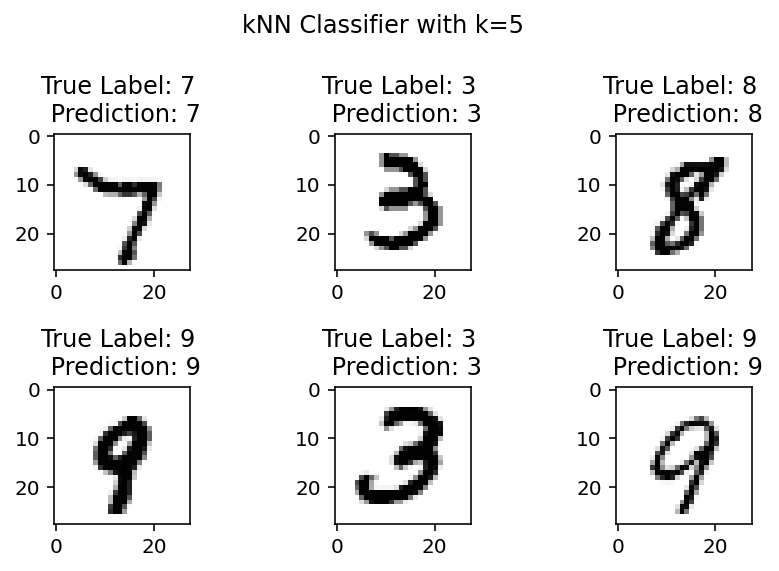

In [297]:
visualize_6_digits((0,1,2,3,4,5))

## Performance

In [235]:
# get predictions with k=5
k=5
predictions,locations=knn_classifier(image_train,label_train,image_test,k)

### Confusion Matrix and Metrics

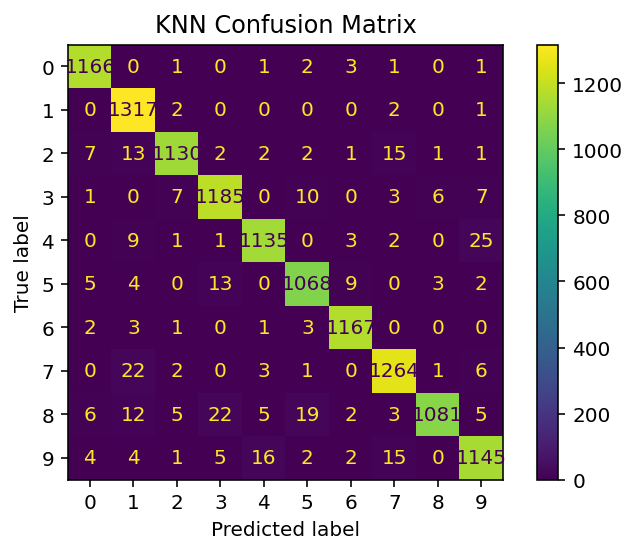

In [268]:
cm=confusion_matrix(label_test,predictions)

ConfusionMatrixDisplay(cm).plot()
plt.title('KNN Confusion Matrix')
plt.show();

In [305]:
smoothing = 1**-6 # add to avoid division by zero

accuracy=np.sum(predictions==label_test)/len(predictions)*100
recall =(np.diag(cm)+smoothing)/(np.sum(cm,axis=1)+smoothing)
precision = (np.diag(cm)+smoothing)/(np.sum(cm,axis=0)+smoothing)
f1_score = 2*(recall*precision/(recall+precision))

print(f'The accuracy of this model is: {accuracy}%.\n')
print(f'The recall for each class is: {recall}. The macro-average is {np.mean(recall)}. \n ')
print(f'The precision for each class is: {precision}. The macro-average is {np.mean(precision)}.\n')
print(f'The f1 score for each class is: {f1_score}. The macro-average is {np.mean(f1_score)}.')

The accuracy of this model is: 97.15%.

The recall for each class is: [0.99234694 0.99622071 0.96255319 0.97213115 0.96516568 0.96742081
 0.99151104 0.97307692 0.93195521 0.95899582]. The macro-average is 0.9711377463893103. 
 
The precision for each class is: [0.97902685 0.95162455 0.98262381 0.96501221 0.97594502 0.96480144
 0.98316498 0.96860643 0.98993596 0.95979899]. The macro-average is 0.9720540232107886.

The f1 score for each class is: [0.98564189 0.97341211 0.97248495 0.9685586  0.97052542 0.96610935
 0.98732037 0.97083653 0.96007098 0.95939724]. The macro-average is 0.9714357447783819.


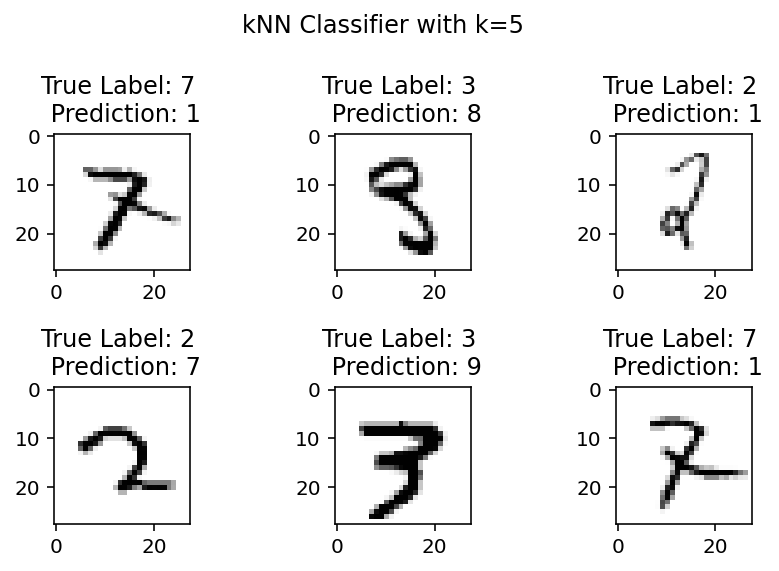

In [300]:
# pick 6 random failures and display
failure_ind=np.where(predictions!=label_test)[0]
visualize_6_digits(np.random.choice(failure_ind,6))

## Conclusion

I found that the k-nearest neighbor algorithm was suprisingly powerful in classifying handwritten digits from the MNIST database. I was particularly impressed with the performance metrics, with a 97.15% accuracy rate and ~.97 macro-average recall, precision, and F1-score.

## References

- MTH448 Weekly Jupyter Notebooks and Exercises
- [NumPy Documentation](https://numpy.org/doc/stable/index.html) 
- https://adityassrana.github.io/blog/broadcasting/numpy/2020/07/24/Vectorization.html

In [333]:
def get_dist_no_loop(test,train):
    dist = np.zeros((train.shape[0], test.shape[0]))
    dist=np.sqrt((test**2).sum(axis=1)[:, np.newaxis] + (train**2).sum(axis=1) - 2 * test.dot(train.T))
    return dist

In [334]:
def get_dist_loop(test,train):
    dists=[]
    for t in test:
        dists.append(np.linalg.norm(t-train,axis=1))
    return dists

In [65]:
image_train_flat = image_train.reshape(len(image_train),28*28)[:100]
labels_train_flat=label_test[:100]

image_test_flat = image_test.reshape(len(image_test),28*28)[:800]

In [338]:
%time dist=get_dist_loop(image_test_flat,image_train_flat);

CPU times: user 287 ms, sys: 108 ms, total: 395 ms
Wall time: 409 ms


In [339]:
%time dist=get_dist_no_loop(image_test_flat,image_train_flat);

CPU times: user 43.4 ms, sys: 3.52 ms, total: 46.9 ms
Wall time: 47.3 ms


In [5]:
# helper function to find kNN
def find_kNN(X,p,k):
    dist = np.linalg.norm(X-p,axis=1) # get all euclidean distances btw test and train
    return np.argsort(dist)[:k] # sort top k neighbor indices

# classifier
def knn_classifier(training_images, training_labels, x, n):
    
    # reshape appropriately 
    training_images=training_images.reshape((training_images.shape[0], 28*28))
    x=x.reshape((28*28)) # flatten
    
    knn=find_kNN(training_images,x,n)
    label_index=knn[-1] # obtain furthest neighbor index
    
    return (training_labels[label_index], knn) # return furthest neighbor and neighbor array